In [ ]:
!pip install transformers


#finetune
!pip install -U accelerate
!pip install datasets
!pip install -U peft 
!pip install -U torchkeras 
!pip install -U  huggingface_hub
!export HF_ENDPOINT=https://hf-mirror.com 

In [1]:
import numpy as np
import pandas as pd 
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader 

In [2]:
# 配置参数
from argparse import Namespace
cfg = Namespace()

#dataset
cfg.prompt_column = 'prompt'
cfg.response_column = 'response'
cfg.history_column = None
cfg.source_prefix = '[扮演gji]' #添加到每个prompt开头的前缀引导语
cfg.source_prefix = ''

cfg.max_source_length = 64 
cfg.max_target_length = 128

#model
cfg.model_name_or_path = 'THUDM/chatglm2-6b'  #远程'THUDM/chatglm-6b' 
cfg.data_path = 'play-with-instruct-model/ds/resp.jsonl'
cfg.quantization_bit = None #仅仅预测时可以选 4 or 8 


#train
cfg.epochs = 50 
cfg.lr = 5e-3
cfg.batch_size = 1
cfg.gradient_accumulation_steps = 16 #梯度累积


In [3]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

In [4]:
import pandas as pd

# #对prompt使用一些简单的数据增强的方法，以便更好地收敛。
# def get_prompt_list(keyword):
#     return [f'{keyword}', 
#             f'你知道{keyword}吗?',
#             f'{keyword}是什么？',
#             f'介绍一下{keyword}',
#             f'你听过{keyword}吗?',
#             f'啥是{keyword}？',
#             f'{keyword}是何物？',
#             f'何为{keyword}？',
#            ]
# ps: 这里样本构建同一个问题，一定要构建多种提问方式，不然就会过拟合(提问时严格与样本对应才会正确输出)。
import jsonlines
def jsonl_load(file):
    ret = []
    with jsonlines.open(file) as lines:
        for obj in lines:
            ret.append(obj)
    return ret
# data =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
data = jsonl_load(cfg.data_path)
dfdata = pd.DataFrame(data)
display(dfdata) 

,prompt,response
0,你是什么血型?,AB型
1,你喜欢玩游戏吗?,比较喜欢，不过现在能让人废寝忘食的游戏太少了。都是一些为了拖游戏时间，而设置了一大堆无聊障
2,你最喜欢哪座城市?,最喜欢的城市还没出现，现在比较喜欢昆明、苏州，再就是上海、再有云贵川的一些小城市。
3,你今年多大?,我永远20岁。
4,你今年多大?,我永远20岁，你明年问我还是这个回答。
5,你喜欢的户外运动有哪些?,我喜欢的户外运动有足球、网球、羽毛球、骑行、户外探险、露营等等
6,你是什么星座?,双子座。
7,你来上海多久?,出生就在上海
8,你为什么在上海待呢?,单纯因为工作需要&出生在上海，个人喜欢上海，
9,你是什么性格，幽默风趣嘛?,我比较喜欢幽默，但是经常出梗都是类似谐音梗之类的烂梗。


In [5]:
import transformers
from transformers import  AutoModel,AutoTokenizer,AutoConfig,DataCollatorForSeq2Seq


config = AutoConfig.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name_or_path, trust_remote_code=True)

model = AutoModel.from_pretrained(cfg.model_name_or_path,config=config,
                                  trust_remote_code=True).half() 

#先量化瘦身
if cfg.quantization_bit is not None:
    print(f"Quantized to {cfg.quantization_bit} bit")
    model = model.quantize(cfg.quantization_bit)
    
#再移动到GPU上
model = model.cuda();
print(tokenizer.eos_token_id, tokenizer.pad_token_id)

2025-03-02 22:50:34.333175: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 22:50:34.374783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-02 22:50:35.164787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2 0


In [6]:
#!pip install torchkeras==3.9.1
#!pip install transformers==4.40.2

In [7]:
# 通过注册jupyter魔法命令可以很方便地在jupyter中测试ChatGLM 
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(model,tokenizer)

register magic %%chatglm sucessed ...
你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [8]:

def preprocess(examples, cfg=cfg, tokenizer=tokenizer):
    max_seq_length = cfg.max_source_length + cfg.max_target_length
    model_inputs = {
        "input_ids": [],
        "labels": [],
    }
    for i in range(len(examples[cfg.prompt_column])):
        if examples[cfg.prompt_column][i] and examples[cfg.response_column][i]:
            query, answer = examples[cfg.prompt_column][i], examples[cfg.response_column][i]

            history = examples[cfg.history_column][i] if cfg.history_column is not None else None
            prompt = tokenizer.build_prompt(query, history)

            prompt = cfg.source_prefix + prompt
            a_ids = tokenizer.encode(text=prompt, add_special_tokens=True, truncation=True,
                                     max_length=cfg.max_source_length)
            b_ids = tokenizer.encode(text=answer, add_special_tokens=False, truncation=True,
                                     max_length=cfg.max_target_length)

            context_length = len(a_ids)
            input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
            labels = [tokenizer.pad_token_id] * context_length + b_ids + [tokenizer.eos_token_id]

            pad_len = max_seq_length - len(input_ids)
            input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
            labels = labels + [tokenizer.pad_token_id] * pad_len
            labels = [(l if l != tokenizer.pad_token_id else -100) for l in labels]
            model_inputs["input_ids"].append(input_ids)
            model_inputs["labels"].append(labels)
    return model_inputs

In [9]:
import datasets 
#训练集和验证集一样
ds_train_raw = ds_val_raw = datasets.Dataset.from_pandas(dfdata)


In [10]:
ds_train = ds_train_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_train_raw.column_names
)

ds_val = ds_val_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_val_raw.column_names
)

Map (num_proc=4):   0%|          | 0/31 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/31 [00:00<?, ? examples/s]

In [11]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=False
)

dl_train = DataLoader(ds_train,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = True, collate_fn = data_collator 
                     )
dl_val = DataLoader(ds_val,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = False, collate_fn = data_collator 
                     )

In [12]:
from peft import get_peft_model, AdaLoraConfig, TaskType

#训练时节约GPU占用
model.config.use_cache=False
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
    target_modules=["query", "value"]
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()


You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


trainable params: 2,924,880 || all params: 6,246,508,908 || trainable%: 0.04682423483386154


In [ ]:
#!pip install peft==0.4.0

In [19]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None, tokenizer=tokenizer
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
        self.tokenizer = tokenizer
        self.i = 0
    
    def __call__(self, batch):
        self.i += 1
        sents = []
        #loss
        with self.accelerator.autocast():
            ret = self.net(input_ids=batch["input_ids"],labels=batch["labels"])
            if self.stage != 'train' and self.i > 20:
                inp_ids = batch['input_ids'].cpu().numpy()
                pred_ids = torch.argmax(ret.logits, dim=-1).cpu().numpy()
                for i in range(pred_ids.shape[0]):
                    src = self.tokenizer.decode(inp_ids[i])
                    stop = np.where(pred_ids==self.tokenizer.eos_token_id)[0]
                    
                    # sent = self.tokenizer.decode(pred_ids[i][:stop])
                    # print(src, sent)
                    # sents.append(sent)
            loss = ret.loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        # step_metrics['sents'] = str(sents)
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 

In [20]:
optimizer = torch.optim.AdamW(peft_model.parameters(),lr=cfg.lr) 
keras_model = KerasModel(peft_model,loss_fn = None,
        optimizer=optimizer) 
ckpt_path = 'gji'

Detected kernel version 4.19.91, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


<<<<<< ⚡️ cuda is used >>>>>>


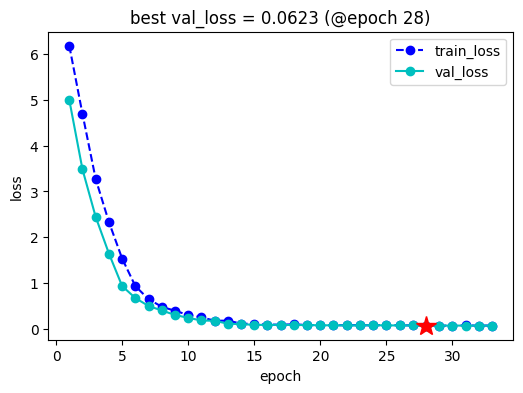

[2025-03-02 22:56:07,303] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


df: /root/.triton/autotune: 没有那个文件或目录
/usr/local/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


<<<<<< val_loss without improvement in 5 epoch,early stopping >>>>>>


,epoch,train_loss,lr,val_loss
0,1,6.185736,0.005,5.000473
1,2,4.692918,0.005,3.479303
2,3,3.268744,0.005,2.440587
3,4,2.330472,0.005,1.641381
4,5,1.531707,0.005,0.929892
5,6,0.928900,0.005,0.667386
6,7,0.642933,0.005,0.494007
7,8,0.476901,0.005,0.396146
8,9,0.388908,0.005,0.298088
9,10,0.298190,0.005,0.234485


In [21]:
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=cfg.epochs,
                patience=5,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16',
                gradient_accumulation_steps = cfg.gradient_accumulation_steps
               )

In [22]:
# from generation import generate
# for batch in dl_val:
#     input_ids = batch['input_ids']
#     break
# model_new = peft_model.merge_and_unload().cuda()
# chatglm = ChatGLM(model_new, tokenizer, max_chat_rounds=20)

ModuleNotFoundError: No module named 'generation'

In [24]:
from peft import PeftModel 
from transformers import AutoModel
from argparse import Namespace
cfg = Namespace()
#model
cfg.model_name_or_path = 'THUDM/chatglm2-6b'  #远程'THUDM/chatglm-6b' 
cfg.ckpt = 'gji'
# ckpt_path = 
model_old = AutoModel.from_pretrained(cfg.model_name_or_path,
                                  load_in_4bit=False, 
                                  trust_remote_code=True)
peft_loaded = PeftModel.from_pretrained(model_old, cfg.ckpt).cuda()
model_new = peft_loaded.merge_and_unload() #合并lora权重

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [25]:
peft_loaded = peft_loaded.merge_and_unload() #合并lora权重
from torchkeras.chat import ChatGLM 
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name_or_path, trust_remote_code=True)
chatglm = ChatGLM(model_new, tokenizer, max_chat_rounds=0, temperature=0.01) #支持多轮对话，可以从之前对话上下文提取知识。

register magic %%chatglm sucessed ...
你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [27]:

%%chatglm

你是谁,你叫什么？

我叫huichuan ，可以叫我川川


In [28]:
%%chatglm

你的血型？

A型。


In [29]:
%%chatglm

喜欢玩游戏吗？

比较喜欢，不过现在能让人废寝忘食的游戏太少了。都是一些为了拖游戏时间，而设置了一大堆无聊障


In [30]:
%%chatglm
喜欢骑行吗？

还行，我骑行主要是为了通勤，顺便为了锻炼一下身体，最近一次骑行30公里。
